In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset path
data_dir = "/content/drive/MyDrive/animal/animals/animals"

# Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
dataset = ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Number of classes
num_classes = len(dataset.classes)


In [ ]:
# CRNN model
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
        )
        self.rnn = nn.LSTM(input_size=64 * 16, hidden_size=128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.cnn(x)  # (B, C, H, W) -> (B, 64, 16, 16)
        x = x.permute(0, 3, 1, 2)  # (B, W, C, H)
        x = x.reshape(x.size(0), x.size(1), -1)  # (B, W, C*H)
        _, (hn, _) = self.rnn(x)  # (num_layers, B, H)
        out = self.fc(hn[-1])     # Final output
        return out

# Initialize model
model = CRNN(num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")

# Save model
save_path = "/content/drive/MyDrive/animal/animalscrnn_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Epoch [1/20], Loss: 31.1119, Accuracy: 14.79%
Epoch [2/20], Loss: 30.0359, Accuracy: 23.96%
Epoch [3/20], Loss: 28.7046, Accuracy: 27.92%
Epoch [4/20], Loss: 27.1692, Accuracy: 34.58%
Epoch [5/20], Loss: 24.4738, Accuracy: 42.50%
Epoch [6/20], Loss: 22.4385, Accuracy: 46.88%
Epoch [7/20], Loss: 19.5108, Accuracy: 56.25%
Epoch [8/20], Loss: 17.3702, Accuracy: 59.58%
Epoch [9/20], Loss: 15.5236, Accuracy: 66.04%
Epoch [10/20], Loss: 14.0261, Accuracy: 71.25%
Epoch [11/20], Loss: 11.4385, Accuracy: 78.33%
Epoch [12/20], Loss: 9.7374, Accuracy: 79.17%
Epoch [13/20], Loss: 8.0823, Accuracy: 86.46%
Epoch [14/20], Loss: 6.2830, Accuracy: 90.00%
Epoch [15/20], Loss: 5.5727, Accuracy: 92.50%
Epoch [16/20], Loss: 4.6095, Accuracy: 94.38%
Epoch [17/20], Loss: 3.0732, Accuracy: 97.50%
Epoch [18/20], Loss: 2.2400, Accuracy: 98.33%
Epoch [19/20], Loss: 1.6554, Accuracy: 99.17%
Epoch [20/20], Loss: 1.2380, Accuracy: 98.96%
Model saved to /content/drive/MyDrive/animal/animalscrnn_model.pth


In [ ]:
# Save model
save_path = "/content/drive/MyDrive/animal/animalscrnn_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/animal/animalscrnn_model.pth


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the same CRNN model again (must match training)
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.rnn = nn.LSTM(input_size=64 * 16, hidden_size=128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)
        _, (hn, _) = self.rnn(x)
        out = self.fc(hn[-1])
        return out

# Load class names (from training dataset)
from torchvision.datasets import ImageFolder
data_dir = "/content/drive/MyDrive/animal/animals/animals"
dummy_dataset = ImageFolder(data_dir)
class_names = dummy_dataset.classes
num_classes = len(class_names)

# Initialize and load the model
model = CRNN(num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/animal/animalscrnn_model.pth', map_location=device))
model.to(device)
model.eval()


CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): LSTM(1024, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)

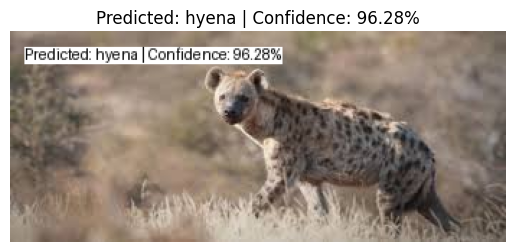

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F

# Path to test image
test_img_path = "/content/Hyenaaa.jpeg"

# Load original image for display
display_image = Image.open(test_img_path).convert("RGB")

# Ensure a minimum image size for drawing
if display_image.size[0] < 128 or display_image.size[1] < 128:
    display_image = display_image.resize((128, 128))

# Transform image for model input
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
input_tensor = transform(display_image).unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

    # Calculate confidence (softmax gives the probabilities)
    probabilities = F.softmax(output, dim=1)
    confidence = probabilities[0][predicted.item()] * 100  # Multiply by 100 for percentage

# Draw text on the image
draw = ImageDraw.Draw(display_image)
text = f"Predicted: {predicted_class} | Confidence: {confidence:.2f}%"

# Dynamically adjust font size based on image height
image_width, image_height = display_image.size
font_size = max(16, image_height // 15)  # Font size is 1/15th of the image height

# Load a readable font
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", font_size)
except:
    font = ImageFont.load_default()

# Get text box dimensions
text_position = (10, 10)
text_box = draw.textbbox(text_position, text, font=font)

# Draw white rectangle behind text for visibility
draw.rectangle(text_box, fill=(255, 255, 255))

# Draw text on top
draw.text(text_position, text, fill=(0, 0, 0), font=font)

# Show image
plt.imshow(display_image)
plt.axis("off")
plt.title(f"Predicted: {predicted_class} | Confidence: {confidence:.2f}%")
plt.show()
